In [87]:
# imports

import os
import pprint
import pickle
import glob
import json
import re
import string
import datetime

from collections import defaultdict

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [10]:
# utility objects

MILLISEC_PER_MONTH = 1000 * 60 * 60 * 24 * 30

pp = pprint.PrettyPrinter(indent=4)
def print_term_to_senders():
    pp.pprint(term_to_senders)
    
standard_contractions = set(["aren't", "can't", "could've", "couldn't", "didn't", 
            "doesn't", "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", 
            "how'd", "how'll", "how's", "i'd", "i'll", "i'm", "i've", "isn't", "it'd", 
            "it'll", "it's", "let's", "might've", "mightn't", "must've", 
            "mustn't", "needn't", "o'clock", "she'd", "she'll", "she's", 
            "should've", "shouldn't", "that'd", "that's", "there'd", 
            "there's", "they'd", "they'll", "they're", "they've", "wasn't", 
            "we'd", "we'll", "we're", "we've", "weren't", "what'll", "what're", "what's",
            "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", 
            "who's", "who've", "why's", "won't", "would've", 
            "wouldn't", "you'd", "you'll", "you're", "you've"])

# add in all contractions without the apostrophes also
new_contractions = set()
for contraction in standard_contractions:
    new_contractions.add(contraction.replace("'", ""))

standard_contractions = standard_contractions.union(new_contractions)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()

In [11]:
# helper functions

def preprocess(words):
    words = words.lower()
    # weird thing with apostrophe showing up as this unicode string
    words = re.sub("\u00e2\u0080\u0099", "'", words)
    # filter out all remaining Unicode, TODO: maybe want to translate these into emojis?
    words = words.encode("ascii", "ignore").decode("UTF-8")
    return words

def print_sorted_dict(d, first_x=None):
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for i, key in enumerate(sorted_keys):
        if first_x is not None and i >= first_x:
            break
        print(f"Rank {i+1}:", key, d[key])
    return sorted_keys

def is_contraction(word):
    if "'" in word:
        split_word = word.split("'")
        if len(split_word) > 1 and split_word[0] in english_words:
            return True
    return False

terms_to_include = set(["kys"])
def exclude_word(word):
    return (len(word) < 1 or word in english_words or word.isdigit() 
            or is_contraction(word) or word in standard_contractions) and (word not in terms_to_include)

In [12]:
pickled_dict_fname = "term_to_senders_dict"
term_to_senders = pickle.load(open(pickled_dict_fname, "rb")) 

# {
#     "<term>": {
#         "<friend_name>": 
#             {
#                  "<friend_name>": [<list of timestamps in ms>],
#                  "<account_user_name>": [<list of timestamps in ms>]
#             }
#         ....
#     },
#     ....
# }

In [101]:
# define terms for analysis
msg_dir = "/home/lhuang21/Documents/SideProjects/Grapevine/facebook-lawrenceh1850/messages/inbox"
account_user_name = "Lawrence Huang"
TERM = "okay"
FRIEND_NAME = "Dan J Chong"

In [97]:
# calculate moving average

def term_freq_avg(start_time_milli, end_time_milli, term, friend_name, msg_dir):
    """
    Calculates average term frequency per word in a given time frame for all users involved in conversation.
    """
    if start_time_milli > end_time_milli:
        raise ValueError("End time must be after start time.")
    
    dir_prefix = friend_name.strip().replace(" ", "").lower()
    msg_file_path = os.path.join(msg_dir, dir_prefix + "*")
    candidate_dirs = glob.glob(msg_file_path)
    
    # this is for determining whether the term is a single word
    # bigram or trigram
    term_dimension = 1
    if isinstance(term, tuple):
        term_dimension = len(term)
    
    if len(candidate_dirs) != 1:
        raise ValueError("Invalid path for friend name and message directory specified")
    else:
        msg_file_path = os.path.join(candidate_dirs[0], "message_1.json") 
        
        # make sure file exists
        if not os.path.exists(msg_file_path):
            raise ValueError(f"{msg_file_path} doesn't exist")
        else:
            json_dict = json.load(open(msg_file_path, 'r'))

            word_count_in_period = {}
            term_count_in_period = {}
            
            for name_dict in json_dict["participants"]:
                participant_name = name_dict["name"]
                term_count_in_period[participant_name] = 0
                word_count_in_period[participant_name] = 0

            for index, msg in enumerate(reversed(json_dict['messages'])):
                msg_timestamp_ms = msg["timestamp_ms"]
                sender = msg["sender_name"]
                
                if msg_timestamp_ms >= start_time_milli:
                    if msg_timestamp_ms > end_time_milli:
                        break
                    
                    try:
                        content = preprocess(msg["content"])
                    except KeyError:
                        # in case there isn't a content key
                        continue
                    tok_content = content.split()
                    
                    word_count_in_period[sender] += len(tok_content)
                    
                    if term_dimension == 1:
                        # monograms
                        for word in tok_content:
                            word = word.strip(string.punctuation)
                            if len(word) > 0:
                                # only lemmatize if this was not a hand-picked word
                                if word not in terms_to_include:
                                    word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                                if word == term:
                                    term_count_in_period[sender] += 1
                    elif term_dimension == 2:
                        # bigrams
                        for (tok1, tok2) in ngrams(tok_content, 2):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            if term == (tok1, tok2):
                                term_count_in_period[sender] += 1
                    elif term_dimension == 3:
                        # trigrams
                        for (tok1, tok2, tok3) in ngrams(tok_content, 3):
                            tok1 = tok1.strip(string.punctuation)
                            tok2 = tok2.strip(string.punctuation)
                            tok3 = tok3.strip(string.punctuation)
                            if term == (tok1, tok2, tok3):
                                term_count_in_period[sender] += 1
                    else:
                        raise ValueError(f"Term has invalid input dimension")
                        
            for sender in term_count_in_period:
                if word_count_in_period[sender] != 0:
                    term_count_in_period[sender] /= float(word_count_in_period[sender])
                else:
                    # sender had no words in this period
                    term_count_in_period[sender] = 0
                
            return term_count_in_period

In [102]:
friend_timestamps = term_to_senders[TERM][FRIEND_NAME][FRIEND_NAME]
user_timestamps = term_to_senders[TERM][FRIEND_NAME][account_user_name]

first_mention = None
last_mention = None
# no mentions
if len(friend_timestamps) == 0 and len(user_timestamps) == 0:
    pass
elif len(friend_timestamps) == 0:
    first_mention = user_timestamps[0]
    last_mention = user_timestamps[0]
elif len(user_timestamps) == 0:
    first_mention = friend_timestamps[0]
    last_mention = friend_timestamps[0]
else:
    first_mention = min(friend_timestamps[0], user_timestamps[0])
    last_mention = max(friend_timestamps[-1], user_timestamps[-1])

if first_mention is not None and last_mention is not None:
    x_axis = []
    friend_usage_rates = []
    user_usage_rates = []
    
    START_MS = first_mention
    END_MS = START_MS + MILLISEC_PER_MONTH
    while START_MS <= last_mention:
        rate_dict = term_freq_avg(START_MS, END_MS, TERM, FRIEND_NAME, msg_dir)
        START_MS = END_MS
        END_MS = START_MS + MILLISEC_PER_MONTH
        x_axis.append(datetime.datetime.utcfromtimestamp(START_MS / 1000).replace(tzinfo=datetime.timezone.utc))
        friend_usage_rates.append(rate_dict[FRIEND_NAME])
        user_usage_rates.append(rate_dict[account_user_name])
else:
    raise ValueError(f"No mentions of {TERM} found for {FRIEND_NAME}")

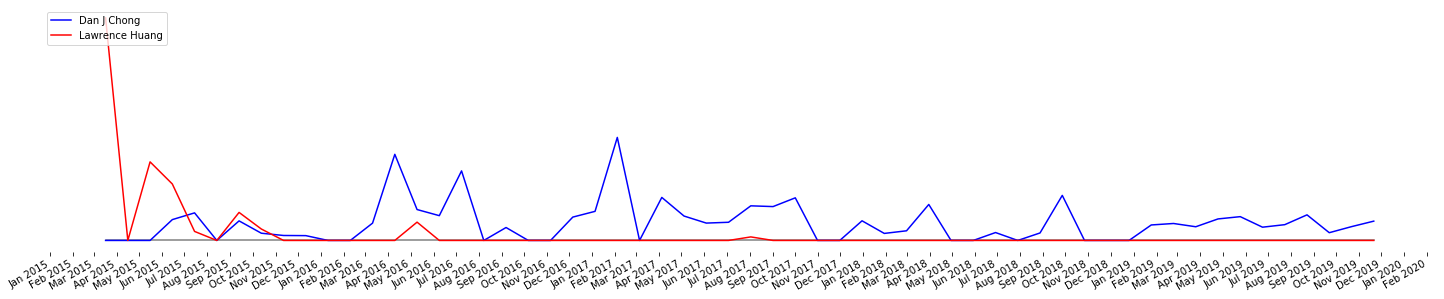

In [107]:
friend_usage_rates = np.asarray(friend_usage_rates)
user_usage_rates = np.asarray(user_usage_rates)

# Create the base line
start = x_axis[0]
stop = x_axis[-1]

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

ax.plot(x_axis, friend_usage_rates, label=f"{FRIEND_NAME}", c='b')
ax.plot(x_axis, user_usage_rates, label=f"{account_user_name}", c='r')

ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()

plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
              list(ax.spines.values())), visible=False)

plt.legend(loc='upper left');
plt.show()